In [1]:
import os
import matplotlib.pyplot as plt
from collections import OrderedDict

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from torchvision import transforms
from torchvision.datasets import MNIST

import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint


if not os.path.exists("data/MNIST"):
    MNIST("data", train=True, download=True)
    MNIST("data", train=False, download=True)

batch_size = 256
num_workers = 8
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize([0.5], [0.5])
])
    
mnist_full = MNIST("data", train=True, transform=transform)
train_data, valid_data = random_split(mnist_full, [55000, 5000])
test_data = MNIST("data", train=False, transform=transform)

train_dataloader = DataLoader(train_data, batch_size=batch_size, num_workers=num_workers)
valid_dataloader = DataLoader(valid_data, batch_size=batch_size, num_workers=num_workers)
test_dataloader = DataLoader(test_data, batch_size=batch_size, num_workers=num_workers)

In [2]:
class Generator(nn.Module):
    def __init__(self, alpha=0.2, latent_dim=100):
        super().__init__()
        self.alpha = alpha
        
        self.block_1 = nn.Sequential(
            nn.Linear(100, 128),
            nn.BatchNorm1d(num_features=128)
        )
        
        self.block_2 = nn.Sequential(
            nn.Linear(128, 256),
            nn.BatchNorm1d(num_features=256)
        )
        
        self.block_3 = nn.Sequential(
            nn.Linear(256, 512),
            nn.BatchNorm1d(num_features=512)
        )
        
        self.block_4 = nn.Sequential(
            nn.Linear(512, 784)
        )
        

    def forward(self, x):
        x = F.leaky_relu(self.block_1(x), self.alpha)
        x = F.leaky_relu(self.block_2(x), self.alpha)
        x = F.leaky_relu(self.block_3(x), self.alpha)
        x = self.block_4(x)
        
        return F.tanh(x)
    
    
class Discriminator(nn.Module):
    def __init__(self, alpha=0.2):
        super().__init__()
        self.alpha = alpha
        
        self.block_1 = nn.Sequential(
            nn.Linear(784, 512)
        )
        
        self.block_2 = nn.Sequential(
            nn.Linear(512, 256)
        )
        
        self.block_3 = nn.Sequential(
            nn.Linear(256, 1)
        )
        
        
    def forward(self, x):
        x = F.leaky_relu(self.block_1(x), self.alpha)
        x = F.leaky_relu(self.block_2(x), self.alpha)
        x = self.block_3(x)
        
        return F.sigmoid(x)
    

generator = Generator()
discriminator = Discriminator()

In [4]:
class GAN(pl.LightningModule):
    def __init__(self, generator, discriminator):
        super().__init__()
        self.latent_dim = 100
        self.generator = generator
        self.discriminator = discriminator
    
    
    def forward(self, z):
        return self.generator(z) 
    
    
    def sample_z(self, batch_size):
        return torch.randn(batch_size, self.latent_dim)
    
    
    def generator_step(self, imgs):
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)
        
        z = self.sample_z(imgs.shape[0])
        z = z.type_as(imgs)
        
        g_loss = F.binary_cross_entropy(self.discriminator(self(z)), valid)
        
        return g_loss
    
    
    def discriminator_step(self, imgs):
        valid = torch.ones(imgs.size(0), 1)
        valid = valid.type_as(imgs)

        real_loss = F.binary_cross_entropy(self.discriminator(imgs), valid)
    
        z = self.sample_z(imgs.shape[0])
        z = z.type_as(imgs)
        
        fake = torch.zeros(imgs.size(0), 1)
        fake = fake.type_as(imgs)
        
        fake_loss = F.binary_cross_entropy(self.discriminator(self(z).detach()), fake)

        d_loss = (real_loss + fake_loss) / 2
        
        return d_loss
    
    
    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        # generator
        if optimizer_idx == 0:
            valid = torch.ones(imgs.size(0), 1)
            valid = valid.type_as(imgs)
            
            g_loss = self.generator_step(imgs)
            self.log('train_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
            
            return g_loss
        # discriminator
        elif optimizer_idx == 1:
            d_loss = self.discriminator_step(imgs)
            self.log('train_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
            
            return d_loss
    
    def validation_step(self, batch, batch_idx):
        imgs, _ = batch
        imgs = imgs.view(imgs.size(0), -1)
        
        g_loss = self.generator_step(imgs)
        d_loss = self.discriminator_step(imgs)
        
        self.log('valid_g_loss', g_loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log('valid_d_loss', d_loss, on_step=False, on_epoch=True, prog_bar=True)
    
        
    def configure_optimizers(self):
        opt_g = torch.optim.Adam(self.generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))
        
        return [opt_g, opt_d], []


callbacks = [
    ModelCheckpoint(monitor='valid_g_loss', save_top_k=3, dirpath='weights/GAN', filename='GAN-{epoch:03d}-{valid_g_loss:.4f}-{valid_d_loss:.4f}'),
]
    
model = GAN(generator, discriminator)
trainer = pl.Trainer(gpus=1, max_epochs=50, enable_progress_bar=True, callbacks=callbacks)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [6]:
# trainer.fit(model, train_dataloader, valid_dataloader)

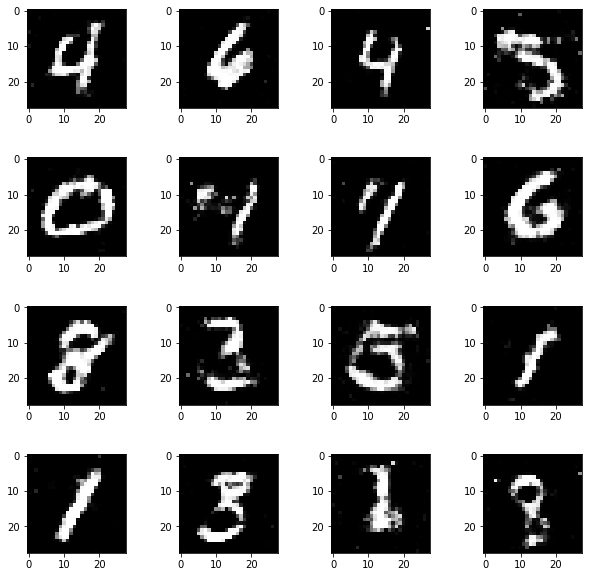

In [11]:
ckpt_fname = "GAN-epoch=047-valid_g_loss=0.5973-valid_d_loss=0.6461.ckpt"
model = model.load_from_checkpoint("weights/GAN/" + ckpt_fname, generator=generator, discriminator=discriminator)

try:
    samples = model(torch.randn(16, 100)).view(-1, 1, 28, 28)
except:
    samples = model(torch.randn(16, 100).to("cuda")).view(-1, 1, 28, 28)
samples = samples.detach().moveaxis(1, -1).to("cpu").numpy()

plt.figure(figsize=(10, 10))
plt.subplots_adjust(hspace=0.5, wspace=0.5)
for i in range(16):
    plt.subplot(4, 4, i + 1)
    plt.imshow(samples[i, :], cmap="gray")

plt.show()